# References

- https://www.imrankhan.dev/pages/Solving%20the%20secretary%20problem%20with%20Python.html

# Pre-requirement

```bash
$ pip install numpy
$ pip install matplotlib
```

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Hyperparameters

- `REJECTS` : determines the proportion of candidates that will be unconditionally rejected during the simulation [%]
- `KS` : represents the number of top candidates to select [integer]
- `TIMEOUTS` : specifies the maximum percentage of candidates that can validate during the simulation [%]
- `N` : represents the total number of candidates [integer]
- `SIMULS` : represents the number of times to run the simulation [interger]

In [2]:
REJECTS = [1] + list(range(1, 101, 5))  # Reject %
KS = [1, 5, 10, 25]  # Best K
TIMEOUTS = list(range(70, 101, 10))  # Timeout % (you can see the TIMEOUT% of candidates maximum)
N = 100  # Number of candidates
SIMULS = 10000  # Number of simulation

print("# of Reject:\t\t", len(REJECTS))
print("# of Best-K:\t\t", len(KS))
print("# of Timeout:\t\t", len(TIMEOUTS))
print("# of Candidates:\t", N)
print("# of Simulation:\t", SIMULS)

# of Reject:		 21
# of Best-K:		 4
# of Timeout:		 4
# of Candidates:	 100
# of Simulation:	 10000


# Logic

The function `pick` returns the chosen candidate from all candidates based on the optimal stopping rule.

- `n` : represents the total number of candidates [integer]
- `reject_percentage` : determines the proportion of candidates that will be unconditionally rejected during the simulation [%]
- `timeout` : specifies the maximum percentage of candidates that can validate during the simulation [%]
- `can_pick_past` : a Boolean parameter that specifies whether the examiner can pick a past candidate or not during the simulation.

In [3]:
def pick(n, reject_percentage, timeout=100, can_pick_past=False):
    candidates = np.arange(1, n + 1)  # priority from 1 to n+1, 1 is best.
    np.random.shuffle(candidates)

    stop = int(round(reject_percentage * n / 100))
    timeout = int(round(len(candidates) * timeout / 100))
    # TODO: must (timeout > stop)

    best_from_rejected = np.min(candidates[:stop])
    rest = candidates[stop:timeout]

    try:
        return rest[rest < best_from_rejected][0]
    except IndexError:
        if can_pick_past:
            return np.min(candidates[:timeout])
        else:
            return candidates[-1]  # pick the last one.

# Case 1) Top-k Optimal Stopping

In [4]:
kos = np.zeros((len(KS), len(REJECTS)))
for ir, r in enumerate(REJECTS):
    res = np.array([pick(N, reject_percentage=r) for _ in range(SIMULS)])
    for ik, k in enumerate(KS):
        kos[ik][ir] = len(res[res <= k]) / 100

np.save("./data/kos", kos)

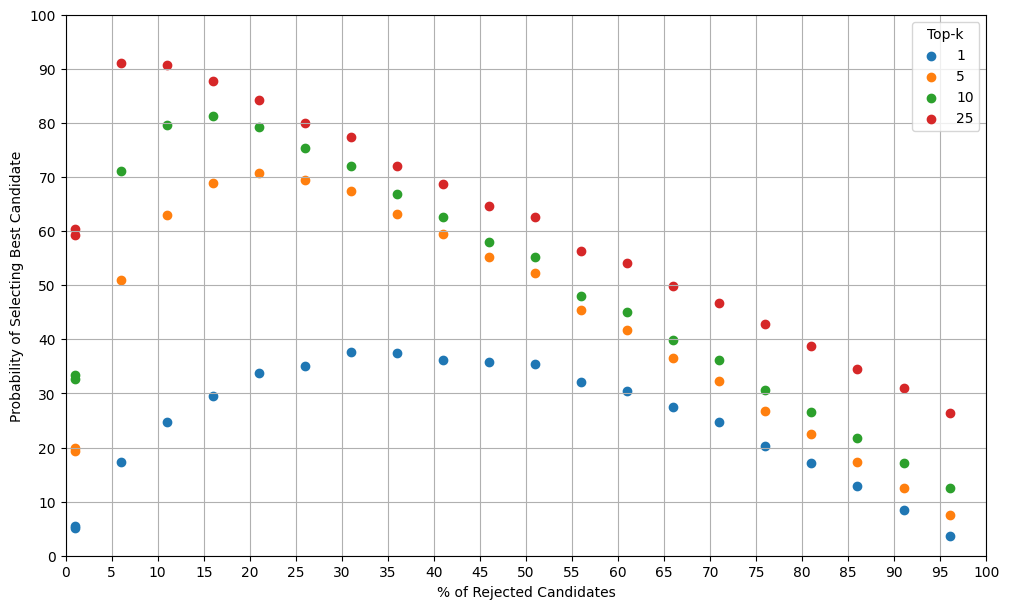

In [5]:
plt.figure(figsize=(10, 6))
plt.xlim(0, 100)
plt.ylim(0, 100)
plt.xticks(np.arange(0, 101, 5))
plt.yticks(np.arange(0, 101, 10))
plt.grid(True)
plt.tight_layout()

for ik, k in enumerate(KS):
    plt.scatter(
        REJECTS,
        kos[ik],
        label=str(k)
    )

plt.xlabel('% of Rejected Candidates')
plt.ylabel('Probability of Selecting Best Candidate')
plt.legend(title='Top-k')

plt.savefig(f"./fig/kos.png", dpi=600)

The simulation results demonstrate that the optimal strategy for picking the top candidate is to reject about 37% (1/e ~= 0.3679) of candidates unconditionally.

If you are willing to pick a candidate in the top-$k$, the success rate significantly increases, and the percentage of candidates rejected also decreases as $k$ increases.

# Case 2) Modified Top-k Optimal Stopping
- can select a passed candidate
- has timeout

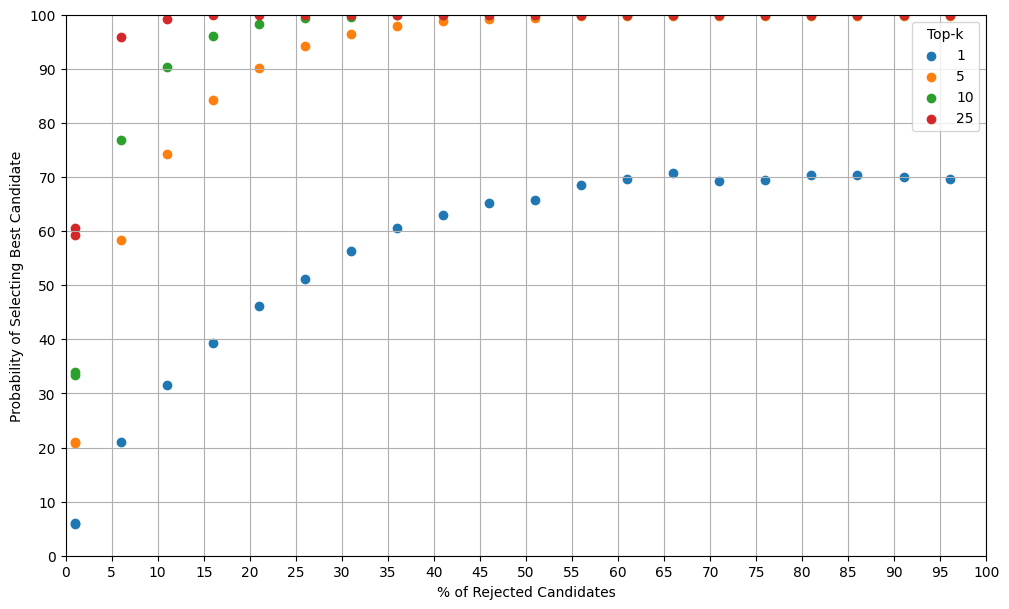

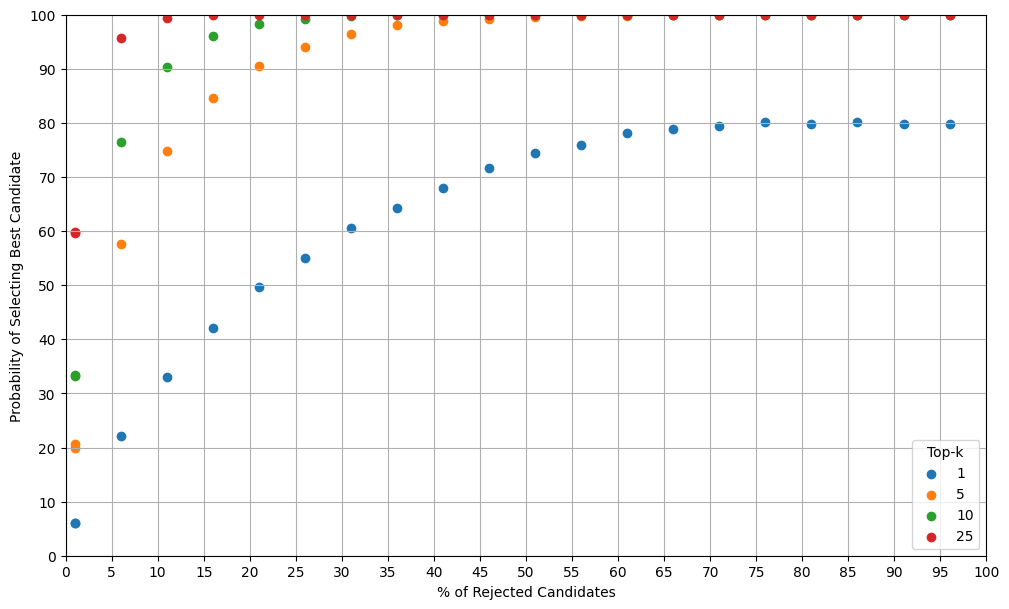

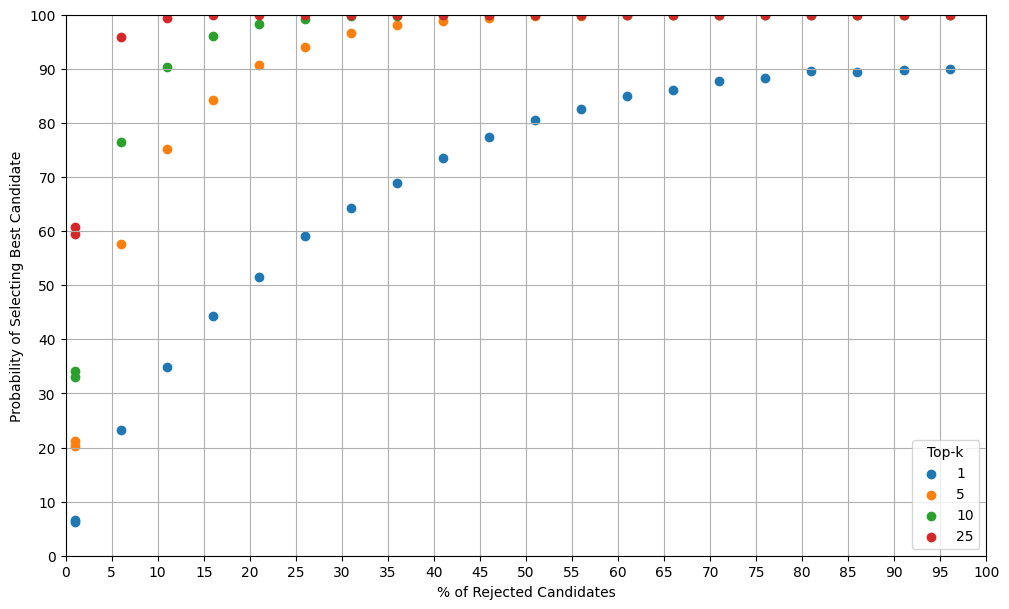

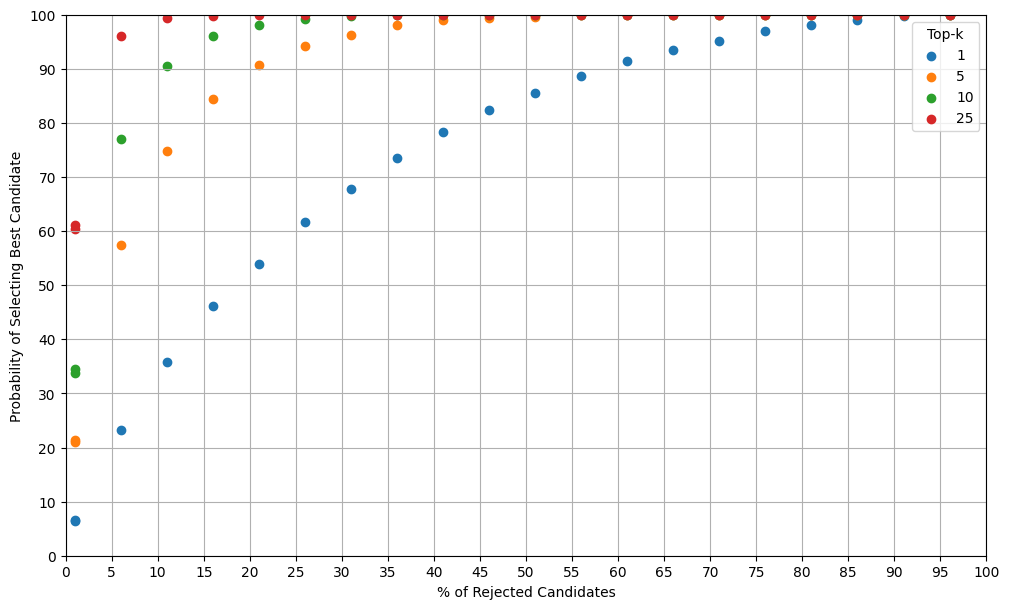

In [6]:
for ts in TIMEOUTS:
    mkos = np.zeros((len(KS), len(REJECTS)))
    for ir, r in enumerate(REJECTS):
        res = np.array([pick(N, reject_percentage=r, timeout=ts, can_pick_past=True) for _ in range(SIMULS)])
        for ik, k in enumerate(KS):
            mkos[ik][ir] = len(res[res <= k]) / 100

    np.save(f"./data/mkos_{ts}", mkos)

    plt.figure(figsize=(10, 6))
    plt.xlim(0, 100)
    plt.ylim(0, 100)
    plt.xticks(np.arange(0, 101, 5))
    plt.yticks(np.arange(0, 101, 10))
    plt.grid(True)
    plt.tight_layout()

    for ik, k in enumerate(KS):
        plt.scatter(
            REJECTS,
            mkos[ik],
            label=str(k)
        )

    plt.xlabel('% of Rejected Candidates')
    plt.ylabel('Probability of Selecting Best Candidate')
    plt.legend(title='Top-k')

    plt.savefig(f"./fig/mkos_{ts}.png", dpi=600)

When it is possible to select from past candidates, the `timeout` parameter dominates, and the success rate converges at the `timeout` [%].

If a candidate is selected from the top-$k$, the success rate increases, and the minimum rejection percentage decreases as $k$ increases.